In [17]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/SSD/Code/TinyMPC/julia/bicycle_tvlqr/Project.toml`


In [80]:
using Plots
using LinearAlgebra
import ForwardDiff as FD

In [34]:
function mat_from_vec(X::Vector{Vector{Float64}})::Matrix
    # convert a vector of vectors to a matrix 
    Xm = hcat(X...)
    return Xm 
end
function vec_from_mat(Xm::Matrix)::Vector{Vector{Float64}}
    # convert a matrix into a vector of vectors 
    X = [Xm[:,i] for i = 1:size(Xm,2)]
    return X 
end
# double integrator dynamics 
function double_integrator_AB(dt)::Tuple{Matrix,Matrix}
    Ac = [0 0 1 0;
          0 0 0 1;
          0 0 0 0;
          0 0 0 0.]
    Bc = [0 0;
          0 0;
          1 0;
          0 1]
    nx, nu = size(Bc)
        
    # TODO: discretize this linear system using the Matrix Exponential
    
    A = zeros(nx,nx) # TODO 
    B = zeros(nx,nu) # TODO 

    mat = exp(dt*[Ac Bc; zeros(nu,nx+nu)])
    A .= mat[1:nx, 1:nx]
    B .= mat[1:nx, nx+1:nx+nu]
    
    @assert size(A) == (nx,nx)
    @assert size(B) == (nx,nu)
    
    return A, B 
end
function get_jacobians!(A, B, f, x0, u0)
    @assert size(A) == (Nx, Nx)
    @assert size(B) == (Nx, Nu)
    @assert size(f) == (Nx,)
    A .= FD.jacobian(_x->rk4(_x, u0), x0)
    B .= FD.jacobian(_u->rk4(x0, _u), u0)
    f .= rk4(x0, u0) - rk4(x0, u0)
end

get_jacobians! (generic function with 1 method)

In [264]:
function eval_mask(μv, huv)  
    # Extract active inequality constraints
    # active set mask
    mask = Diagonal(zeros(length(huv)))
    for i = 1:length(huv)
        mask[i,i] = (μv[i] > 0 || huv[i] > 0)
    end
    mask
end
function ineq_con_u(p,u)
    [u-p.u_max;-u + p.u_min]
end
function ineq_con_u_jac(params, u)
    FD.jacobian(_u -> ineq_con_u(params,_u), u)
end
function tiny_Riccati_LTV!(params, A::Matrix, B::Matrix, f::Vector, 
        get_jacobians::Function, K::Vector, d::Vector, P::Vector, p::Vector, 
        X, U, reg, μ, ρ)::Integer
    
    Q = params.Q; R = params.R; q = params.q; r = params.r; Qf = params.Qf
    # xref = params.xref; uref = params.uref;
    Nx = params.Nx; Nu = params.Nu; N = params.N
    # Copy terminal cost-to-go
    k = N
    P[k] .= Qf
    p[k] .= q + Qf*X[k]

    # Sxx = zeros(n, n)
    # Sxu = zeros(n, m)
    # Sux = zeros(m, n)
    # Suu = zeros(m, m)
    # Sx = zeros(n, 1)
    # Su = zeros(m, 1)

    for k = N-1:-1:1 
        # get_jacobians!(A, B, f, X[k], U[k])
        # K[k] = (R + B' * P[k+1] * B) \ (B' * P[k+1] * A)
        # P[k] = Q + A' * P[k+1] * (A - B * K[k])
        #TODO: 1. cost = 1/2*x'Qx + q'x => Sx (grad_cost) = Qx + q
        
        Sx = q + A' * (P[k+1] * f + p[k+1]) + Q*X[k]
        Su = r + B' * (P[k+1] * f + p[k+1]) + R*U[k]
        Sxx = Q + A'*(P[k+1])*A
        Suu = R + B'*(P[k+1] + reg*I)*B                                     
        Sux = B'*(P[k+1])*A   
        
        # control constraints
        huv = ineq_con_u(params, U[k])  # calculate h(u) constraint
        # println(huv)
        mask = eval_mask(μ[k], huv)  # choose active
        ∇hu = ineq_con_u_jac(params, U[k])
        Su  += ∇hu'*(μ[k] + ρ*(mask * huv)) # add to cost
        Suu += ρ*∇hu'*mask*∇hu

        # display(isposdef(Suu))
        F = cholesky(Symmetric(Suu))
        d[k] .= F\Su
        K[k] .= F\Sux
        
        P[k] .= Sxx + K[k]'*Suu*K[k] - K[k]'*Sux - Sux'*K[k]
        p[k] .= Sx + K[k]'*Suu*d[k] - K[k]'*Su - Sux'*d[k]
    end
    
    return 0;
end
function tiny_RiccatiForwardPass_LTV!(params, A, B, f, get_jacobians::Function,
                                    K::Vector, d::Vector, P::Vector, p::Vector, X::Vector, U::Vector) 
    Xn = deepcopy(X)
    for k=1:N-1
        # get_jacobians!(A, B, f, X[k], U[k])
        U[k] .= U[k] - K[k]*(Xn[k] - X[k]) - d[k]
        Xn[k+1] .= A*Xn[k] + B*U[k]
    end
    X .= Xn
  return 0
end
function tiny_AugmentedLagrangian_LQR!(params, A, B, f, get_jacobians, 
        K::Vector, d::Vector, P::Vector, p::Vector, X::Vector, U::Vector;
        atol=1e-3, max_iters=250, verbose=true, ρ=1, ϕ=10)
    
    # first check the sizes of everything
    @assert length(X) == params.N
    @assert length(U) == params.N-1
    @assert length(X[1]) == params.Nx
    @assert length(U[1]) == params.Nu
    @assert length(ineq_con_u(params,U[1])) == params.Ncu
    
    N = params.N
    for k = 1:N-1
        X[k+1] .= A*X[k] + B*U[k]
    end    
    μ = [zeros(params.Ncu) for i = 1:N-1]   # input constraints
    reg = 1e-8
    
    for iter = 1:max_iters
        tiny_Riccati_LTV!(params, A, B, f, get_jacobians, K, d, P, p, X, U, reg, μ, ρ)
        tiny_RiccatiForwardPass_LTV!(params, A, B, f, get_jacobians, K, d, P, p, X, U) 
        if verbose
            # if rem(iter-1,10)==0
                # display(K[1])
                # display(d[1])
            # end
        end        
        # update multipliers and check constraint violation, max of all
        convio = 0  
        
        # control constraints (inequality)
        for k = 1:N-1
            huv = ineq_con_u(params,U[k])
            mask = eval_mask(μ[k],huv)
            # update dual
            μ[k] = max.(0,μ[k] + ρ*mask*huv)
            convio = max(convio, norm(huv + abs.(huv), Inf))
        end

        @show convio
        if convio < atol  # if terminal condition with contraint violation
            @info "success!"
            return 0;
        end

        ρ *= ϕ  # update penalty
    end
    error("AL-LQR failed!")
end

tiny_AugmentedLagrangian_LQR! (generic function with 6 methods)

In [ ]:
Nt = 101
using DelimitedFiles
uref1 = readdlm("uref_data.txt")
uref1 = reshape(uref1, Nu, Nt-1)
xref1 = readdlm("xref_data.txt")
xref1 = reshape(xref1, Nx, Nt)
uref = [uref1[1:Nu, i] for i = 1:(Nt-1)]
xref = [xref1[1:Nx, i] for i = 1:Nt];

In [272]:
# problem setup stuff 
dt = 0.1 
tf = 5.0 
t_vec = 0:dt:tf 
N = length(t_vec)
A,B = double_integrator_AB(dt)
Nx,Nu = size(B)
f = zeros(Nx)
Q = 1e-2*I(Nx)
q = zeros(Nx)
R = 1e-1*I(Nu)
r = zeros(Nu)
Qf = 100*Q 
umax = 2*[1; 1]; umin = -umax;
# initial condition 
x0 = [5,7,2,-1.4]
params = (
    Nx = Nx,
    Nu = Nu,
    N = N,
    Ncu = 2*Nu,
    #xref = xref,
    #uref = uref,
    Q = Q,
    R = R,
    q = q,
    r = r,
    Qf = Qf,
    u_min = umin,
    u_max = umax,
);

In [273]:
xhist = [1*x0 for i=1:N]
Phist = [zeros(Nx, Nx) for i=1:N]
phist = [zeros(Nx) for i=1:N]
uhist = [.01*randn(Nu) for i=1:N-1]
Khist = [zeros(Nu, Nx) for i=1:N-1]
dhist = [zeros(Nu) for i=1:N-1];
tiny_AugmentedLagrangian_LQR!(params, A, B, f, get_jacobians!, 
        Khist, dhist, Phist, phist, xhist, uhist;
        atol=1e-3, max_iters=10*3, verbose=true, ρ=1, ϕ=10)

convio = 2.723606882911591
convio = 0.9854114194619727
convio = 0.01358968042748554
convio = 0.0


┌ Info: success!
└ @ Main In[264]:118


0

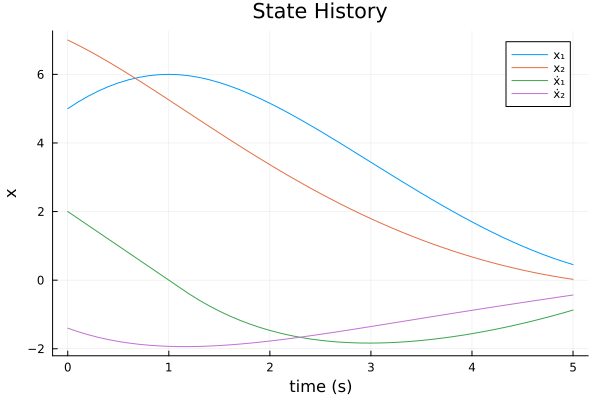

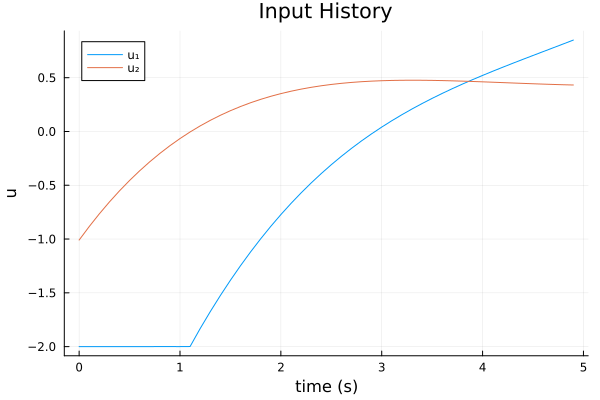

In [274]:
Xsim_m = mat_from_vec(xhist)
Usim_m = mat_from_vec(uhist)
display(plot(t_vec,Xsim_m',label = ["x₁" "x₂" "ẋ₁" "ẋ₂"],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-1],Usim_m',label = ["u₁" "u₂"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))